# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# Импортируем библиотеки 
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
# Ознакомимся с данными
data_0 = pd.read_csv("/datasets/geo_data_0.csv")
data_1 = pd.read_csv("/datasets/geo_data_1.csv")
data_2 = pd.read_csv("/datasets/geo_data_2.csv")
display(data_0.head())
display(data_1.head())
display(data_2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Каждая из таблиц содержит столбец *id*, который не несет полезной информации и дублирует индекс, удалим эти столбцы.

In [3]:
names = [data_0, data_1, data_2]
for name in names:
    name.drop(columns=['id'], inplace=True)

In [4]:
# Проверим на пропуски и дубли
for name in names:
    print(f'Количество строк: {name.shape[0]}')
    print('Количество пропусков:')
    print(name.isnull().sum())
    print()
    print('Количество дубликатов:')
    print(name.duplicated().sum())
    print('=========================================================')

Количество строк: 100000
Количество пропусков:
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов:
0
Количество строк: 100000
Количество пропусков:
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов:
0
Количество строк: 100000
Количество пропусков:
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов:
0


Прекрасно, проблем с данными нет. Посмотрим на значения численных признаков.

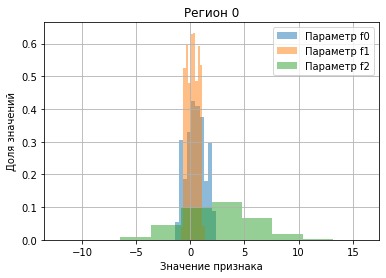

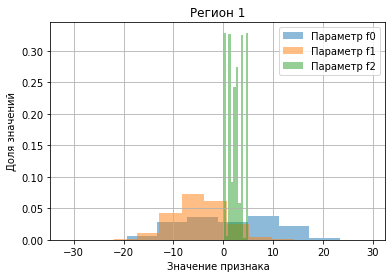

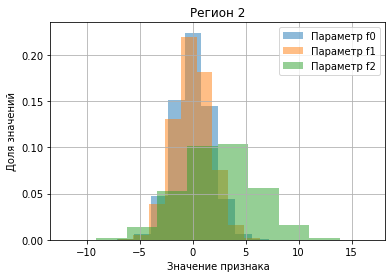

In [5]:
datasets = [data_0, data_1, data_2]
for i in range(len(datasets)):
    plt.title('Регион '+ str(i))
    for col in ['f0', 'f1', 'f2']:
        datasets[i][col].hist(label='Параметр ' + str(col), alpha=0.5, density=True)
    plt.legend()
    plt.xlabel('Значение признака')
    plt.ylabel('Доля значений')
    plt.show()

В целом можно сказать, что признаки имеют одинаковый масштаб. 

## Обучение и проверка модели

Так как у нас три датасета, то напишем функию для экономии времени и места, которая будет разбивать выборку, обучать модель и определять значения метрики

In [6]:
def run_model(data):
    '''
    Функция принимает на вход датасет, подготовлявает признаки, обучает модель 
    и выдает предсказанные значения, истинные значения и RMSE
    '''
    # Создадим датасеты с признаками и целевым признаком. 
    # Затем разделим их на тренировочную и валидационную выборки.
    features = data.drop(columns=['product'])
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    # Подготовим и обучим модель
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = pd.Series(model.predict(features_valid), index=target_valid.index)
    rmse = mean_squared_error(target_valid, predictions) ** 0.5
    return predictions, target_valid, rmse

Получим результаты для каждого региона

In [7]:
datasets = [data_0, data_1, data_2]
predictions = []
targets = []
rmses = []
for i in range(len(datasets)):
    pred, target, rmse = run_model(datasets[i])
    predictions.append(pred)
    targets.append(target)
    rmses.append(rmse)
    print(f"Результаты модели для региона {i}:")
    print(f"Средний запас предсказанного сырья = {pred.mean():.2f} тыс.баррелей")
    print(f"Средний запас сырья массива истинных значений = {target.mean():.2f} тыс.баррелей")
    print(f"RMSE модели на валидационной выборке = {rmse:.2f} тыс.баррелей")
    print('====================================================================')

Результаты модели для региона 0:
Средний запас предсказанного сырья = 92.59 тыс.баррелей
Средний запас сырья массива истинных значений = 92.08 тыс.баррелей
RMSE модели на валидационной выборке = 37.58 тыс.баррелей
Результаты модели для региона 1:
Средний запас предсказанного сырья = 68.73 тыс.баррелей
Средний запас сырья массива истинных значений = 68.72 тыс.баррелей
RMSE модели на валидационной выборке = 0.89 тыс.баррелей
Результаты модели для региона 2:
Средний запас предсказанного сырья = 94.97 тыс.баррелей
Средний запас сырья массива истинных значений = 94.88 тыс.баррелей
RMSE модели на валидационной выборке = 40.03 тыс.баррелей


Посмотрим на распределение значений целевого признака

Доля отрицательных предсказанных значений для региона 0= 0.004%
Доля отрицательных предсказанных значений для региона 1= 2.156%
Доля отрицательных предсказанных значений для региона 2= 0.000%


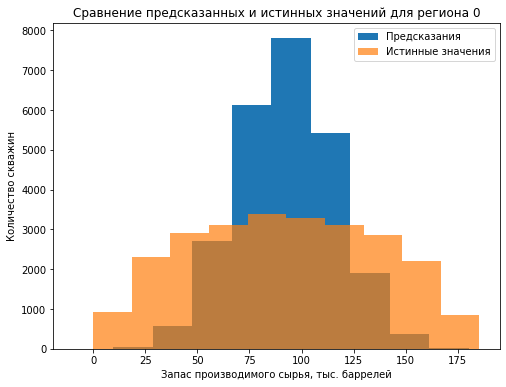

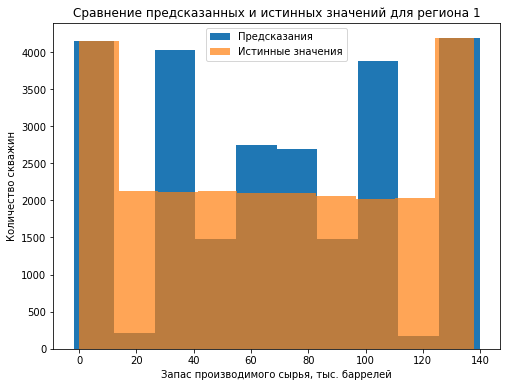

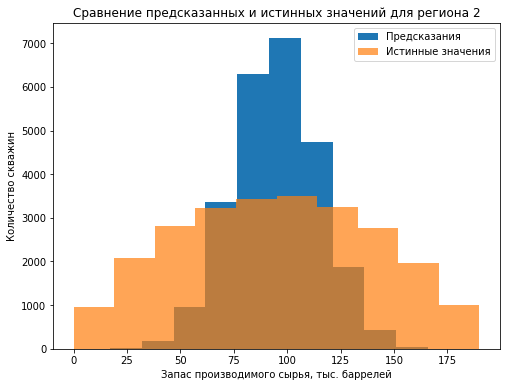

In [8]:
for i in range(len(predictions)):
    plt.figure(figsize=(8,6))
    plt.hist(predictions[i], label='Предсказания')
    plt.hist(targets[i], label='Истинные значения', alpha=0.7)
    plt.legend()
    plt.title("Сравнение предсказанных и истинных значений для региона " + str(i))
    plt.xlabel("Запас производимого сырья, тыс. баррелей")
    plt.ylabel('Количество скважин')
    print(f"Доля отрицательных предсказанных значений для региона {i}= {(predictions[i]< 0).sum() / len(predictions[i]):.3%}")

**Выводы:** Средние значения предсказанных выборок близки к средним истинных значений. Наибольшая точность наблюдается у модели для региона 1, однако стоит отметить, что распределение величин не похоже на нормальное и порядка 2% предсказанных значений отрицательные. Модели для региона 0 и 2 имеют приблизительно одиннаковое качество в виде средних квадратичных отклонений в 37,58 и 40,03 тыс. баррелей соответственно. Также распределения значений имеют более легкие хвосты по сравнению с истинными данными.

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины и сравним полученный объём сырья со средним запасом в каждом регионе. 

In [9]:
# Бюджет на разработку скважин в 1м регионе
BUDGET = 10e9
# Выручка с 1 единицы сырья
PROFIT = 450e3
# Количество лучших скважин в регионе
N_WELLS = 200
# Рассчитаем сколько должна в среднем приносить 1 скважина для безубыточной разработки
INCOME_OF_WELL = BUDGET / N_WELLS / PROFIT
# Сравним требуемую производительсность со срединими предсказанными значениями для каждого региона
for i in range(len(predictions)):
    print(f"Средний объем сырья для региона {i} = {predictions[i].mean():.2f} тыс.баррелей")
print(f"Требуемый объем сырья = {INCOME_OF_WELL:.2f} тыс.баррелей")

Средний объем сырья для региона 0 = 92.59 тыс.баррелей
Средний объем сырья для региона 1 = 68.73 тыс.баррелей
Средний объем сырья для региона 2 = 94.97 тыс.баррелей
Требуемый объем сырья = 111.11 тыс.баррелей


Рассмотрим расспределение производительности скважин по регионам

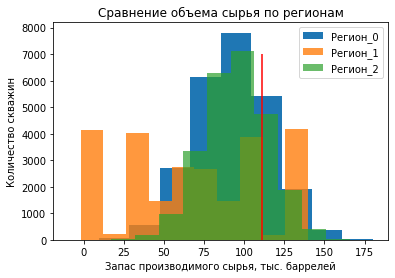

In [10]:
plt.hist(predictions[0], label='Регион_0')
plt.hist(predictions[1], label='Регион_1', alpha=0.8)
plt.hist(predictions[2], label='Регион_2', alpha=0.7)
plt.legend()
plt.title("Сравнение объема сырья по регионам")
plt.xlabel("Запас производимого сырья, тыс. баррелей")
plt.ylabel('Количество скважин')
# Нарисуем линию, которая показывает требуемый уровень добычи
plt.vlines(x=INCOME_OF_WELL, ymin=0, ymax=7000, colors='r')

**Выводы:** Предварительно по средним значениям ни один регион не выполнит норму, хотя наиболее перспективным является регион 2. В таком случае необходимо или увеличить количество скважин, или поднять цены на сырье при сохранении бюджета на разработку скважин. 
Однако, в каждом регионе есть более 200 скважин с производительностью больше требуемой. Чтобы подробнее изучить все картину, необходимо рассмотреть возможные прибыли и убытки.

## Расчёт прибыли и рисков 

Напишием функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [11]:
def calc_profit(pred, target, n_points=200, profit=450e3):
    """
    Функция принимает на вход массив с предсказанным объемом сырья для каждого региона (pred), истинные значения (target),
    количество рассматриваемых скважин (n_points) и прибыль с одной единицы сырья (profit). 
    На выход подается итоговая прибыль с n_points самых прибыльных скважин
    """
    # Найдем топ 200 скважин в регионе
    top_wells = pred.sort_values(ascending=False)[0:n_points]
    # Посчитаем суммарую выручку
    total_income = target[top_wells.index].sum() * profit
    return total_income

Посчитаем риски и прибыль для каждого региона

In [12]:
# Бюджет на разработку скважин в 1м регионе
BUDGET = 10e9
# Количество выборок для Bootstrap метода
BOOTSTRAP_STEPS = 1000
# Количество скважин для рассмотрения в каждом регионе
N_WELLS = 500
# Пройдемся циклом по всем регионам
state = np.random.RandomState(12345)
for i in range(len(predictions)):
    values = []
    for j in range(BOOTSTRAP_STEPS):
        subsample = predictions[i].sample(frac=N_WELLS/len(predictions[i]), replace=True, random_state=state)
        income = calc_profit(subsample, targets[i])
        total_income = income - BUDGET
        values.append(total_income)
    values = pd.Series(values)
    # Среднее значение выручки
    mean_income = values.mean()
    # Найдем границы 95% доверительного интервала
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    # Расчитаем риски убытков, т.е. долю измерений с отрицательной прибылью
    risks = (values < 0).mean()
    print(f"Средняя выручка для региона {i} = {mean_income / 1e9:.2f} млрд. рублей")
    print(f"95% доверительные интервал для региона {i} составлят от {lower/ 1e9:.2f}  млрд. рублей до {upper/ 1e9:.2f}  млрд. рублей")
    print(f"Риски убытков для региона {i} = {risks:.2%}")
    print('================================================================================')

Средняя выручка для региона 0 = 0.40 млрд. рублей
95% доверительные интервал для региона 0 составлят от -0.11  млрд. рублей до 0.91  млрд. рублей
Риски убытков для региона 0 = 6.90%
Средняя выручка для региона 1 = 0.46 млрд. рублей
95% доверительные интервал для региона 1 составлят от 0.08  млрд. рублей до 0.86  млрд. рублей
Риски убытков для региона 1 = 0.70%
Средняя выручка для региона 2 = 0.39 млрд. рублей
95% доверительные интервал для региона 2 составлят от -0.11  млрд. рублей до 0.93  млрд. рублей
Риски убытков для региона 2 = 6.50%


## Выводы

Согласно проведенным исследованиям и результатам обучения модели, наиболее выгодным регионом для разработки является регион №1. Средняя валовая прибыль с 200 скважин этого региона за вычетом 10 млрд. рублей на развитие региона составляет 0.46 млрд.рублей с 95% доверительнм интервалом [0.08, 0.86] млрд. рублей. Риски убытков составляют 0.7%.

Регионы №0 и №2 обладают рисками в 6,9% и 6,5% соотвественно. Средние прибыли - 0,40 и 0,39 млрд. рублей с интервалами [-0.11, 0.91] и [-0.11, 0.93].

Таким образом, несмотря на то, что у региона №1 самое низкое среднее значение объема продукции, он является наиболее перспективным регионом для развития.